In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from matplotlib.pylab import rcParams

from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

In [2]:
rcParams['figure.figsize'] = 15, 6

In [3]:
path_matlab = "../../data/series/series_matlab.csv"
path_fires = "../../data/series/series_fires_acre.csv"

series_matlab = pd.read_csv(path_matlab)
series_fires = pd.read_csv(path_fires, encoding='ISO-8859-1')

# Series Fires

In [4]:
series_fires

,date,number
0,1998-01-01,0.000
1,1998-02-01,0.000
2,1998-03-01,0.000
3,1998-04-01,0.000
4,1998-05-01,0.000
...,...,...
234,2017-07-01,457.000
235,2017-08-01,1.493
236,2017-09-01,3.429
237,2017-10-01,1.508


In [5]:
series_fires['date'] = pd.to_datetime(series_fires['date'])

In [6]:
series_fires = series_fires.set_index('date')

<Axes: xlabel='date'>

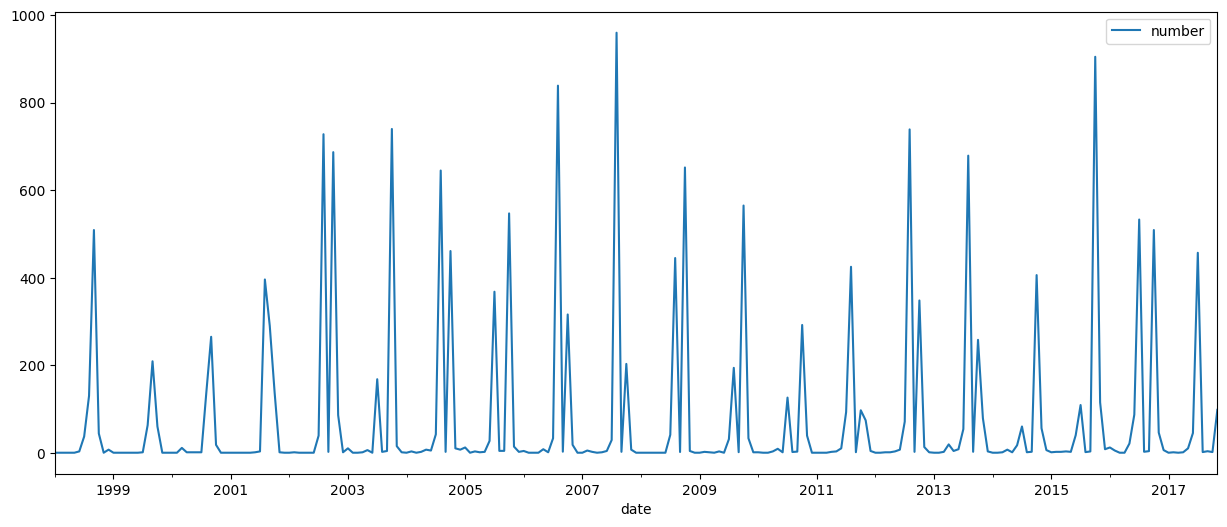

In [7]:
series_fires.plot()

In [8]:
train_fires, val_fires, test_fires = series_fires.loc['1998':'2013'], series_fires.loc['2014':'2015'], series_fires.loc['2016':'2017']

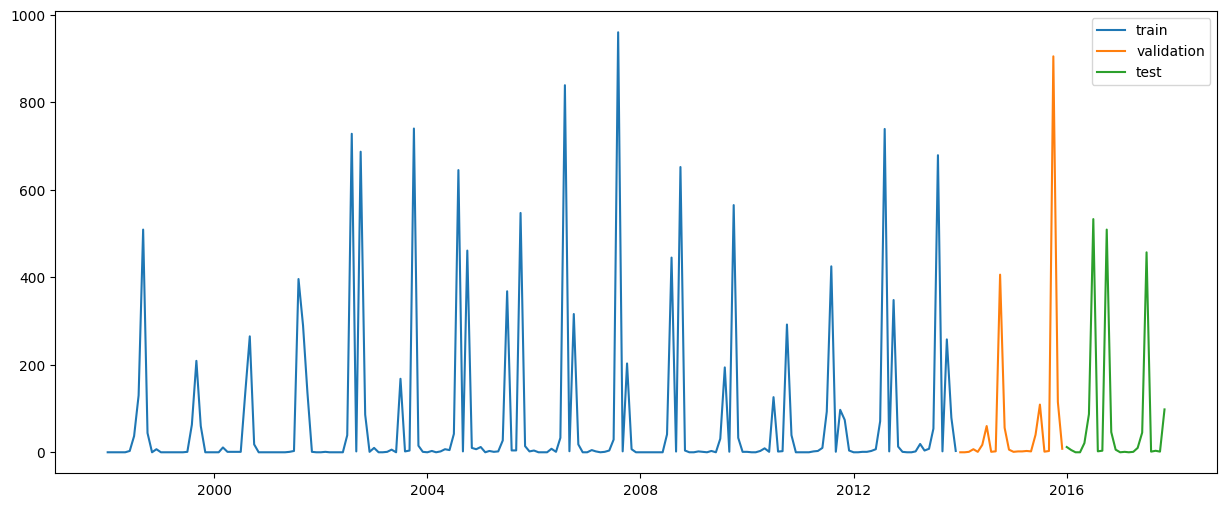

In [9]:
plt.plot(train_fires, label = 'train')
plt.plot(val_fires, label = 'validation')
plt.plot(test_fires, label = 'test')
plt.legend(loc = 'best')
plt.show()

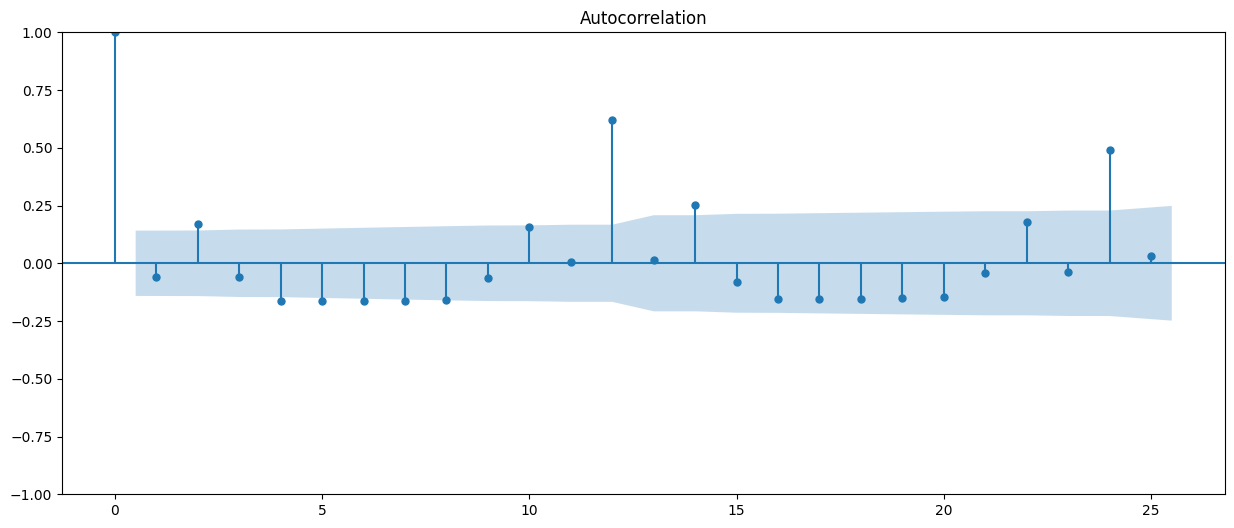

In [10]:
sm.graphics.tsa.plot_acf(train_fires, lags=25)
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


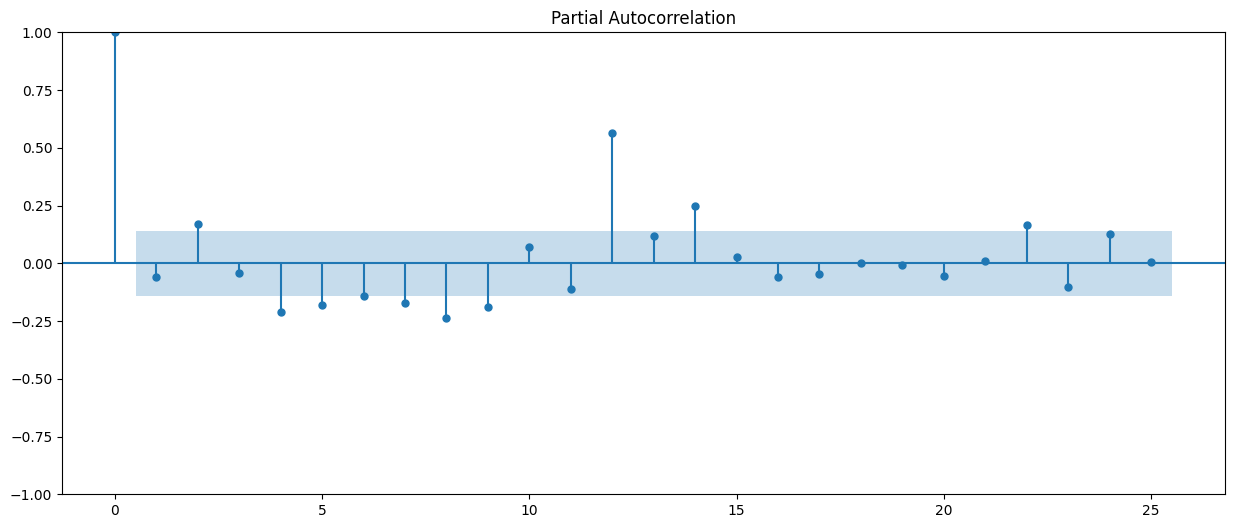

In [11]:
fig = sm.graphics.tsa.plot_pacf(train_fires, lags=25)
plt.show()

In [12]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

In [13]:
train_windows = create_sliding_windows(train_fires, 12)
val_windows = create_sliding_windows(val_fires, 12)
test_windows = create_sliding_windows(test_fires, 12)

In [14]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1]
y_val = val_windows[: , -1]

X_test = test_windows[: ,0: -1]
y_test = test_windows[: , -1]

## Decision Tree Regressor

In [15]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']


best_mse = np.inf
best_criterion = None
best_splitter = None

for c in criterion:
  for s in splitter:
    modelo = DecisionTreeRegressor(criterion=c, splitter=s)
    modelo.fit(X_train, y_train)
    prev_val = modelo.predict(X_val)

    mse = MSE(y_val, prev_val)
    if mse < best_mse:
        best_mse = mse
        best_criterion = c
        best_splitter = s

In [16]:
(best_criterion, best_splitter, best_mse)

('absolute_error', 'random', 12284.978982083334)

In [17]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [18]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

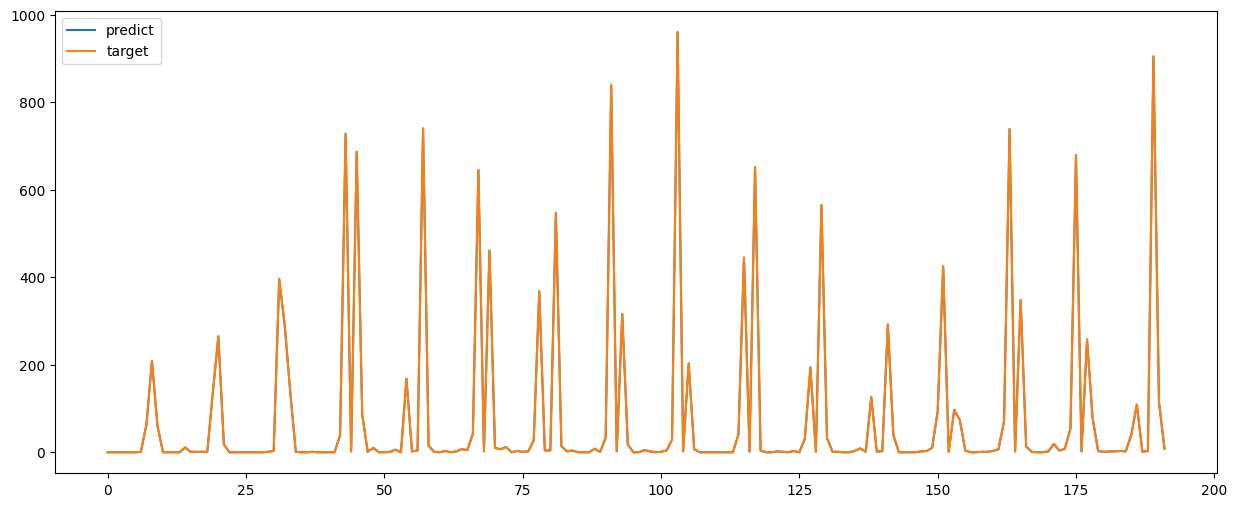

In [19]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [20]:
MSE(y_train_full, prev_train)

0.0

In [21]:
prev_test = modelo.predict(X_test)

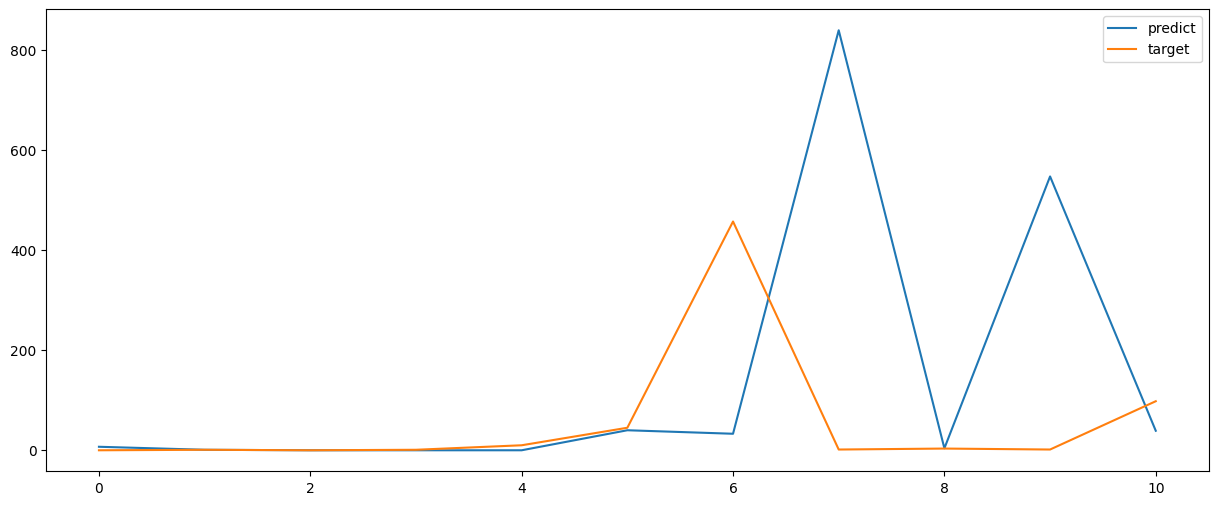

In [22]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [23]:
MSE(y_test, prev_test)

107491.97820745454

### Hyperparameters Tuning

In [24]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depths = [2, 3, 4, 5, 6, 7, 8, 10, 15]
min_samples_split = [2,3,4,5,6]
min_samples_leaf = [1,2,3,4,5]
ccp_alphas = [0.0, 0.001, 0.002, 0.003, 0.004]

best_mse = np.inf
best_criterion = None
best_splitter = None
best_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_ccp_alpha = None

for c in criterion:
  for s in splitter:
    for m in max_depths:
      for mss in min_samples_split:
        for msl in min_samples_leaf:
          for ccp_alpha in ccp_alphas:
            modelo = DecisionTreeRegressor(criterion=c, splitter=s, max_depth=m, min_samples_split=mss, min_samples_leaf=msl, ccp_alpha=ccp_alpha)
            modelo.fit(X_train, y_train)
            prev_val = modelo.predict(X_val)

            mse = MSE(y_val, prev_val)
            if mse < best_mse:
              best_mse = mse
              best_criterion = c
              best_splitter = s
              best_depth = m
              best_min_samples_split = mss
              best_min_samples_leaf = msl
              best_ccp_alpha = ccp_alpha

In [25]:
(best_criterion, best_splitter, best_depth, best_min_samples_split, best_min_samples_leaf, best_ccp_alpha, best_mse)

('absolute_error', 'random', 8, 6, 2, 0.001, 2566.628102416667)

In [26]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [27]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

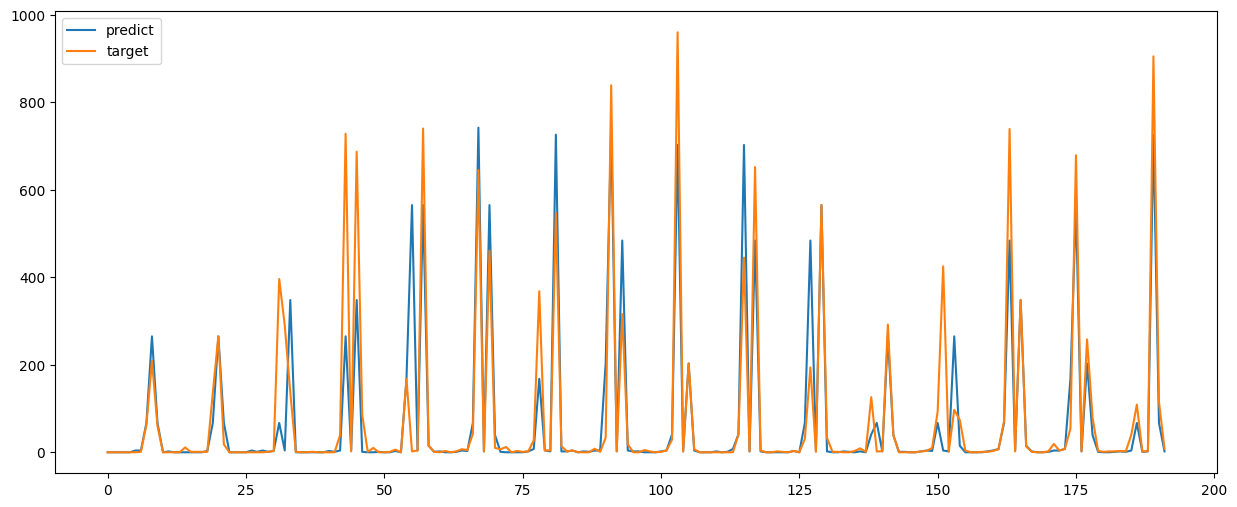

In [28]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [29]:
MSE(y_train_full, prev_train)

8825.550222526042

In [30]:
prev_test = modelo.predict(X_test)

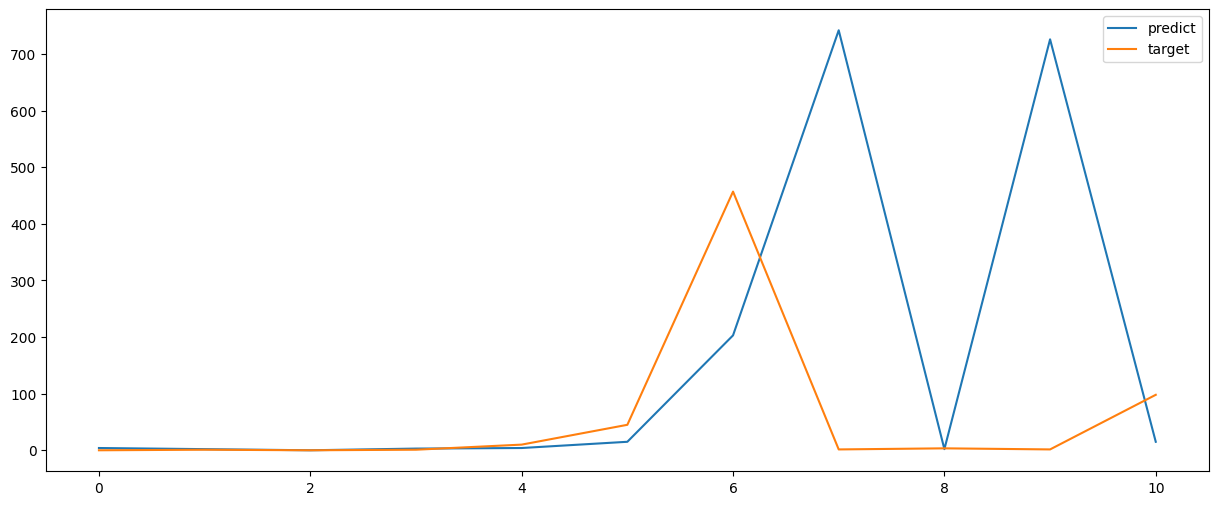

In [31]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [32]:
MSE(y_test, prev_test)

104145.75610490907

### Cross Time Validation

In [33]:
(best_criterion, best_splitter, best_depth, best_min_samples_split, best_min_samples_leaf, best_ccp_alpha, best_mse)

('absolute_error', 'random', 8, 6, 2, 0.001, 2566.628102416667)

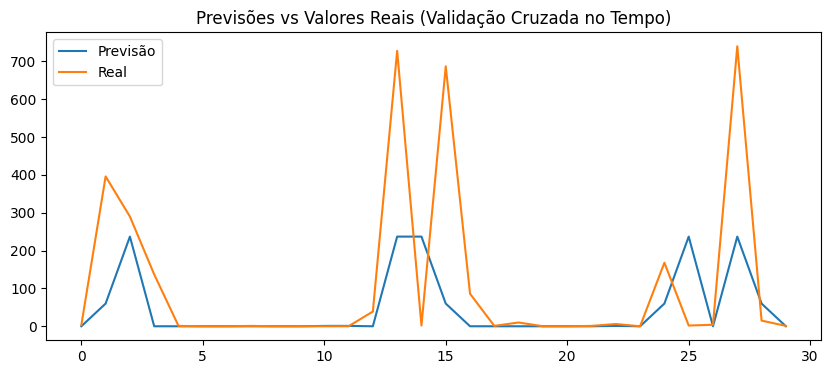

MSE da divisão: 38498.02641803333


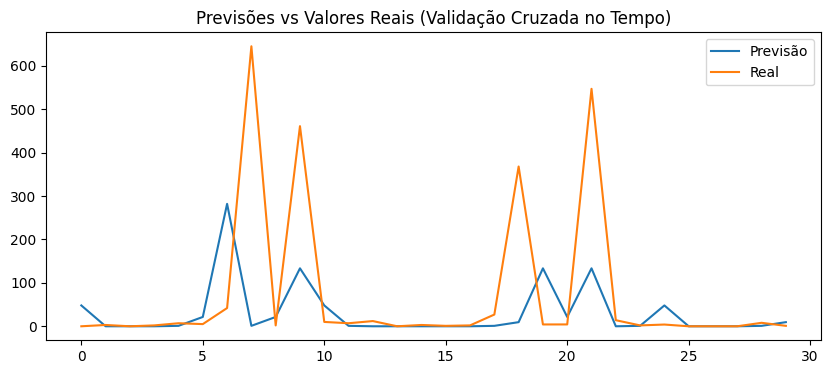

MSE da divisão: 30123.31396006667


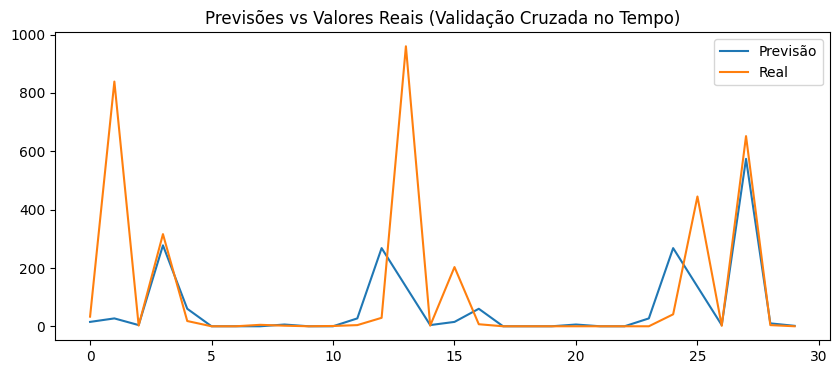

MSE da divisão: 53054.83340395


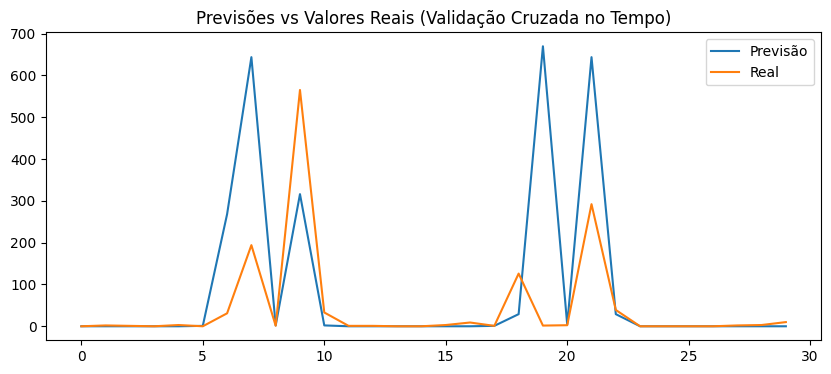

MSE da divisão: 30014.718189041665


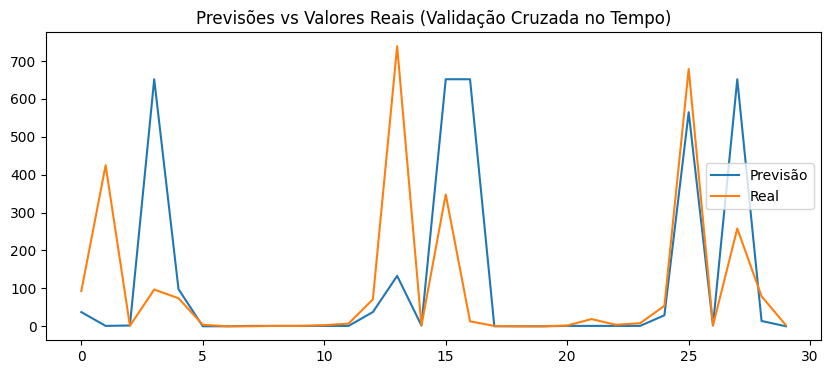

MSE da divisão: 51136.17591893333


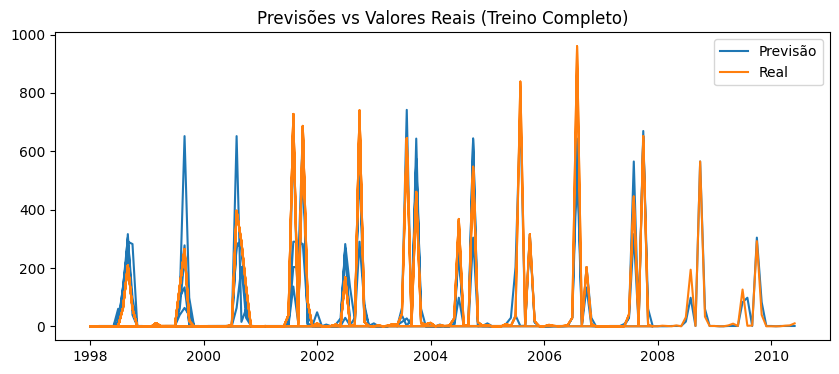

MSE do treino completo: 9395.98544846333


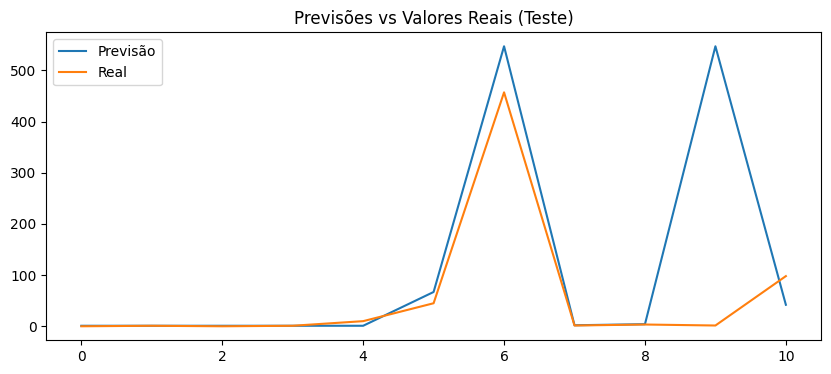

MSE do teste: 28124.11108775


In [34]:
from sklearn.model_selection import TimeSeriesSplit

# Instanciando o TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Listas para armazenar os resultados das previsões e os índices
prev_train_full_all = []
y_train_full_all = []
dates_all = []

# Realizando a validação cruzada no tempo
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
    modelo.fit(X_train_fold, y_train_fold)
    prev_train_fold = modelo.predict(X_train_fold)
    prev_val_fold = modelo.predict(X_val_fold)
    
    prev_train_full_all.extend(prev_train_fold)
    y_train_full_all.extend(y_train_fold)
    dates_all.extend(train_fires.index[train_index])  # Ajuste conforme necessário
    
    # Plotando as previsões e os valores reais para cada divisão
    plt.figure(figsize=(10, 4))
    plt.plot(prev_val_fold, label='Previsão')
    plt.plot(y_val_fold, label='Real')
    plt.title('Previsões vs Valores Reais (Validação Cruzada no Tempo)')
    plt.legend(loc='best')
    plt.show()
    
    print(f'MSE da divisão: {MSE(y_val_fold, prev_val_fold)}')

# Convertendo os resultados em séries temporais
dates = pd.to_datetime(dates_all)
prev_train_series = pd.Series(prev_train_full_all, index=dates)
y_train_series = pd.Series(y_train_full_all, index=dates)

# Plotando as previsões finais para o conjunto de treino completo
plt.figure(figsize=(10, 4))
plt.plot(prev_train_series, label='Previsão')
plt.plot(y_train_series, label='Real')
plt.title('Previsões vs Valores Reais (Treino Completo)')
plt.legend(loc='best')
plt.show()

print(f'MSE do treino completo: {MSE(y_train_series, prev_train_series)}')

# Treinando o modelo final com todos os dados de treino e validação
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

modelo_final = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
modelo_final.fit(X_train_full, y_train_full)

# Fazendo previsões com o modelo final no conjunto de teste
prev_test_final = modelo_final.predict(X_test)

# Plotando as previsões finais para o conjunto de teste
plt.figure(figsize=(10, 4))
plt.plot(prev_test_final, label='Previsão')
plt.plot(y_test, label='Real')
plt.title('Previsões vs Valores Reais (Teste)')
plt.legend(loc='best')
plt.show()

print(f'MSE do teste: {MSE(y_test, prev_test_final)}')


## MLPRegressor

In [35]:
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']

best_mse = np.inf
best_activation = None
best_solver = None
best_learning_rate = None

for a in activation:
  for s in solver:
    for l in learning_rate:
        try:
           
          modelo = MLPRegressor(activation=a, solver=s, learning_rate=l)
          modelo.fit(X_train, y_train)
          prev_val = modelo.predict(X_val)
        
        except:
           print(a,s,l)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_activation = a
            best_solver = s
            best_learning_rate = l

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


identity sgd constant
identity sgd invscaling


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


identity sgd adaptive


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data 

In [36]:
(best_activation, best_solver, best_learning_rate, best_mse)

('tanh', 'lbfgs', 'adaptive', 14964.27181958825)

In [37]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [38]:
modelo = MLPRegressor(activation=best_activation, solver=best_solver, learning_rate=best_learning_rate)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


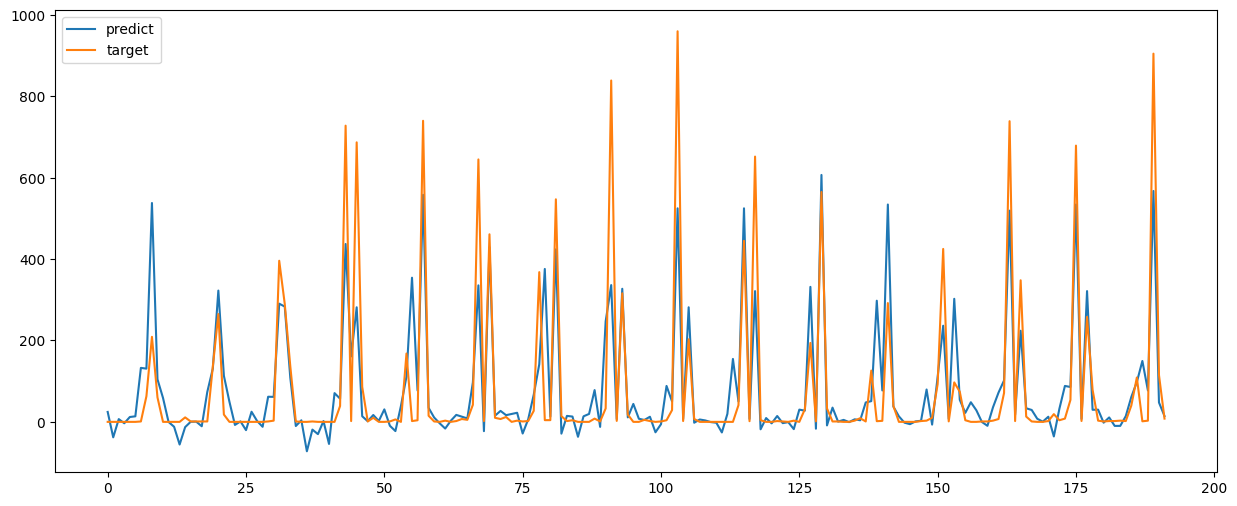

In [39]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [40]:
MSE(y_train_full, prev_train)

11161.878163412932

In [41]:
prev_test = modelo.predict(X_test)

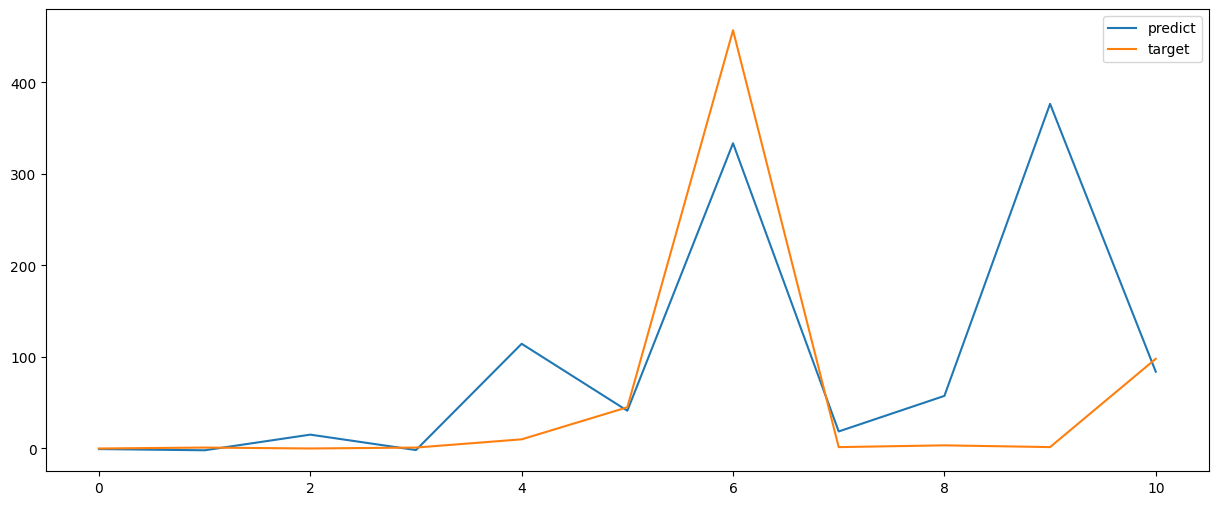

In [42]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [43]:
MSE(y_test, prev_test)

15500.148326025297

## KNeighborsRegressor

In [44]:
neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = [1,2,3,4,5,10,15,20]

best_mse = np.inf
best_neighbors = None
best_weights = None
best_algorithm = None
best_leaf_size = None

for n in neighbors:
  for w in weights:
    for a in algorithm:
      for l in leaf_size:
        modelo = KNeighborsRegressor(n_neighbors=n, weights=w, algorithm=a, leaf_size=l)
        modelo.fit(X_train, y_train)
        prev_val = modelo.predict(X_val)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_neighbors = n
            best_weights = w
            best_algorithm = a
            best_leaf_size = l

In [45]:
(best_neighbors, best_weights, best_algorithm, best_leaf_size, best_mse)

(7, 'uniform', 'auto', 1, 22032.34045277211)

In [46]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [47]:
modelo = KNeighborsRegressor(n_neighbors=best_neighbors, weights=best_weights, algorithm=best_algorithm, leaf_size=best_leaf_size)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

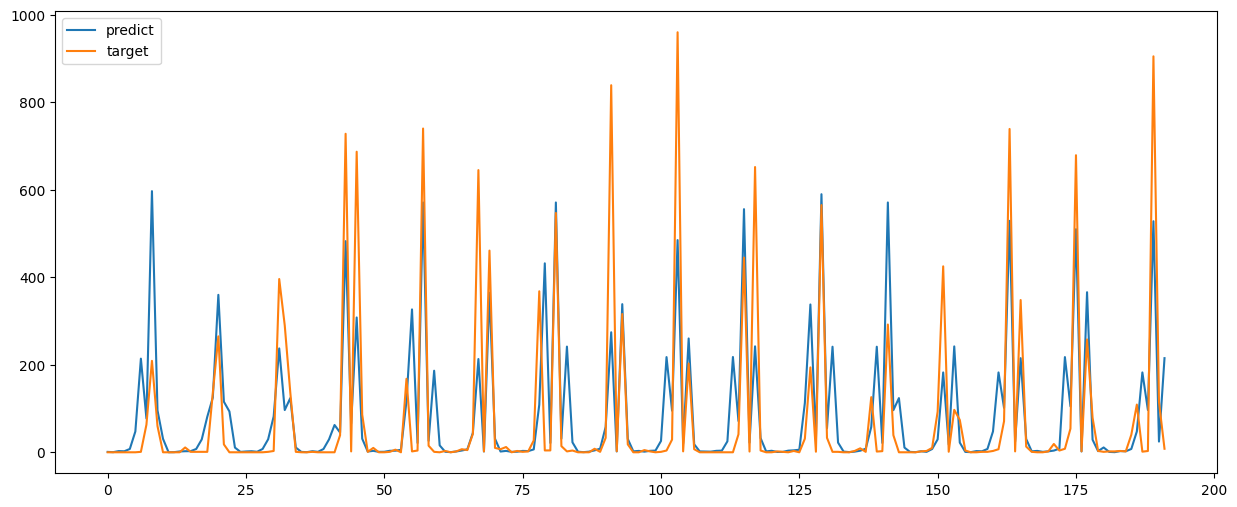

In [48]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [49]:
MSE(y_train_full, prev_train)

14521.362646506059

In [50]:
prev_test = modelo.predict(X_test)

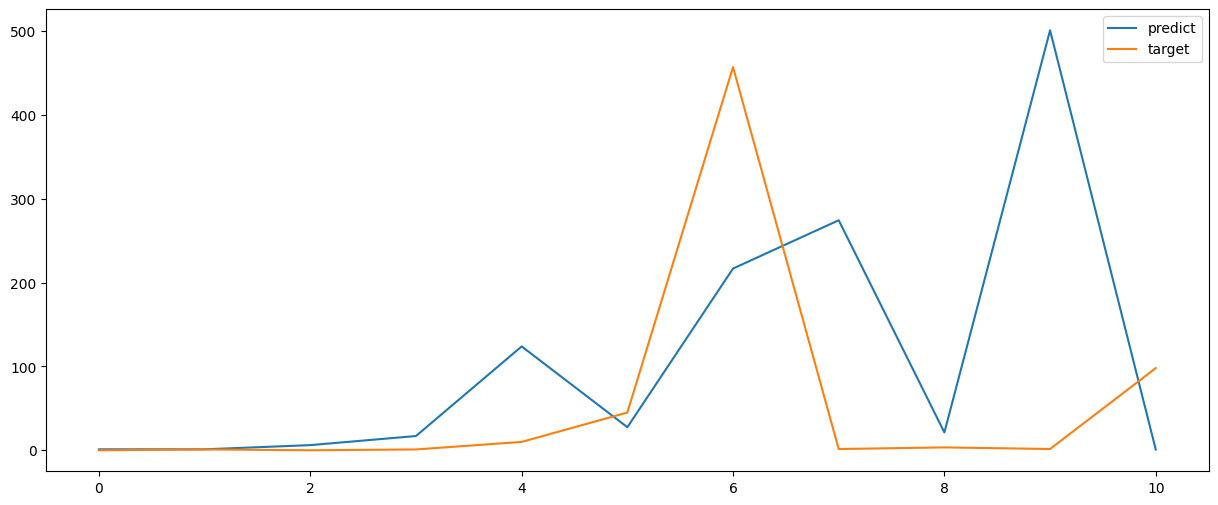

In [51]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [52]:
MSE(y_test, prev_test)

36802.60021992022

# Series Matlab

In [53]:
series_matlab

,month,matlab
0,2009-01-31,19
1,2009-02-28,27
2,2009-03-31,24
3,2009-04-30,32
4,2009-05-31,42
...,...,...
127,2019-08-31,371
128,2019-09-30,362
129,2019-10-31,523
130,2019-11-30,479


In [54]:
series_matlab['month'] = pd.to_datetime(series_matlab['month'])

In [55]:
series_matlab = series_matlab.set_index('month')

<Axes: xlabel='month'>

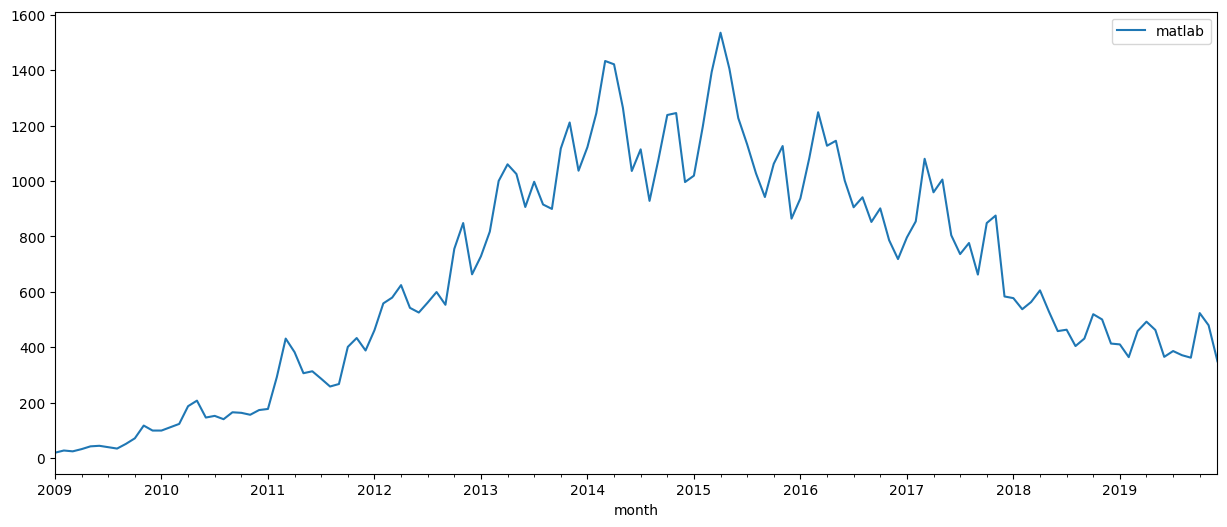

In [56]:
series_matlab.plot()

In [57]:
train_matlab, val_matlab, test_matlab = series_matlab.loc['2009':'2016'], series_matlab.loc['2017'], series_matlab.loc['2018':'2019']

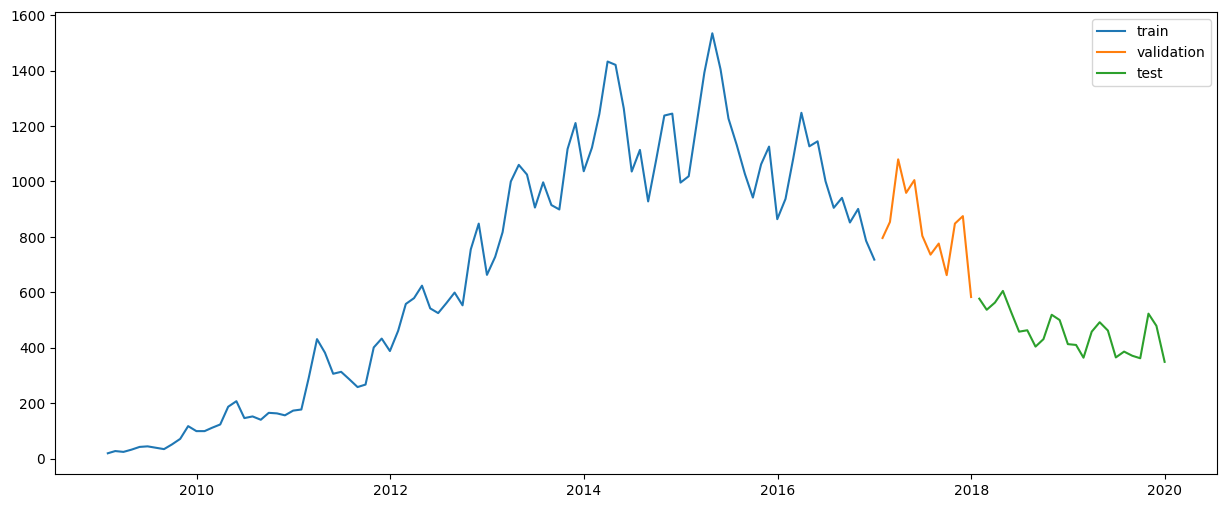

In [58]:
plt.plot(train_matlab, label = 'train')
plt.plot(val_matlab, label = 'validation')
plt.plot(test_matlab, label = 'test')
plt.legend(loc = 'best')
plt.show()

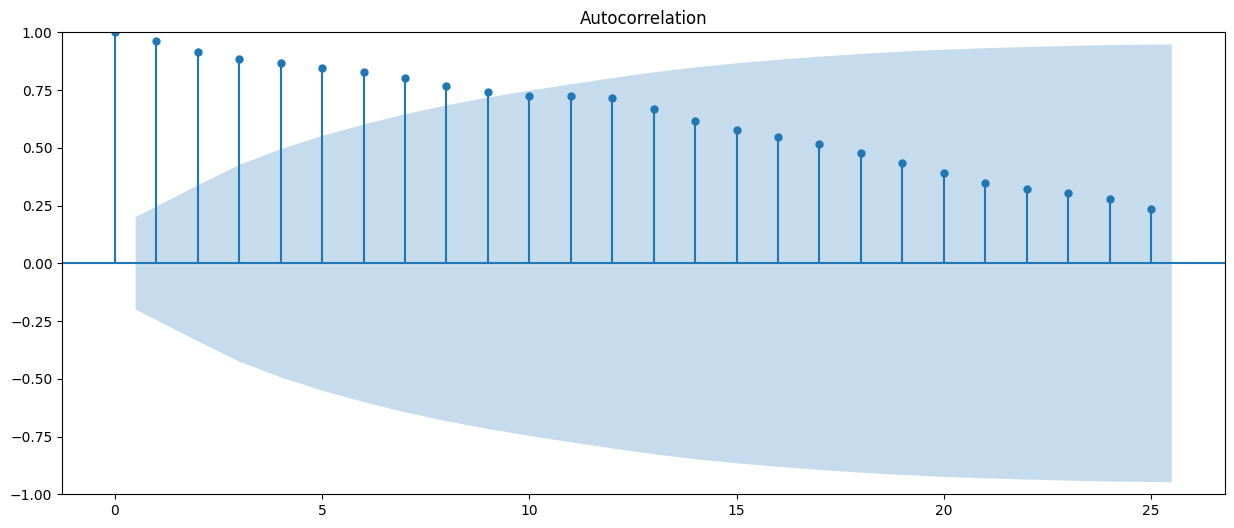

In [59]:
sm.graphics.tsa.plot_acf(train_matlab, lags=25)
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


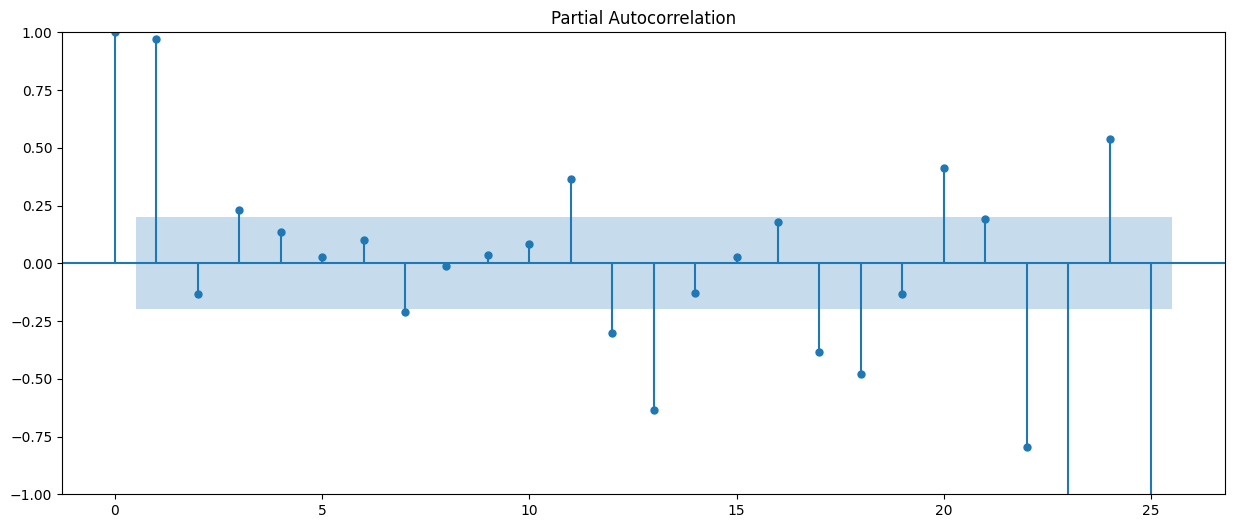

In [60]:
fig = sm.graphics.tsa.plot_pacf(train_matlab, lags=25)
plt.show()

In [61]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

In [62]:
train_windows = create_sliding_windows(train_matlab, 9)
val_windows = create_sliding_windows(val_matlab, 9)
test_windows = create_sliding_windows(test_matlab, 9)

In [63]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1]
y_val = val_windows[: , -1]

X_test = test_windows[: ,0: -1]
y_test = test_windows[: , -1]

## Decision Tree Regressor

In [64]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']


best_mse = np.inf
best_criterion = None
best_splitter = None

for c in criterion:
  for s in splitter:
    modelo = DecisionTreeRegressor(criterion=c, splitter=s)
    modelo.fit(X_train, y_train)
    prev_val = modelo.predict(X_val)

    mse = MSE(y_val, prev_val)
    if mse < best_mse:
        best_mse = mse
        best_criterion = c
        best_splitter = s

In [65]:
(best_criterion, best_splitter, best_mse)

('friedman_mse', 'random', 18984.666666666668)

In [66]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [67]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

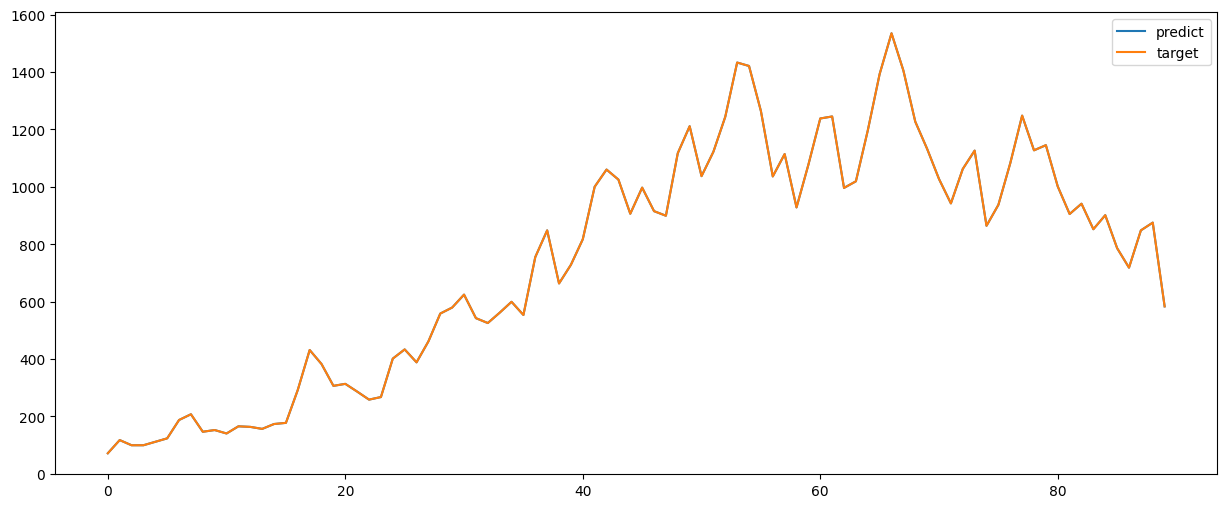

In [68]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [69]:
MSE(y_train_full, prev_train)

0.0

In [70]:
prev_test = modelo.predict(X_test)

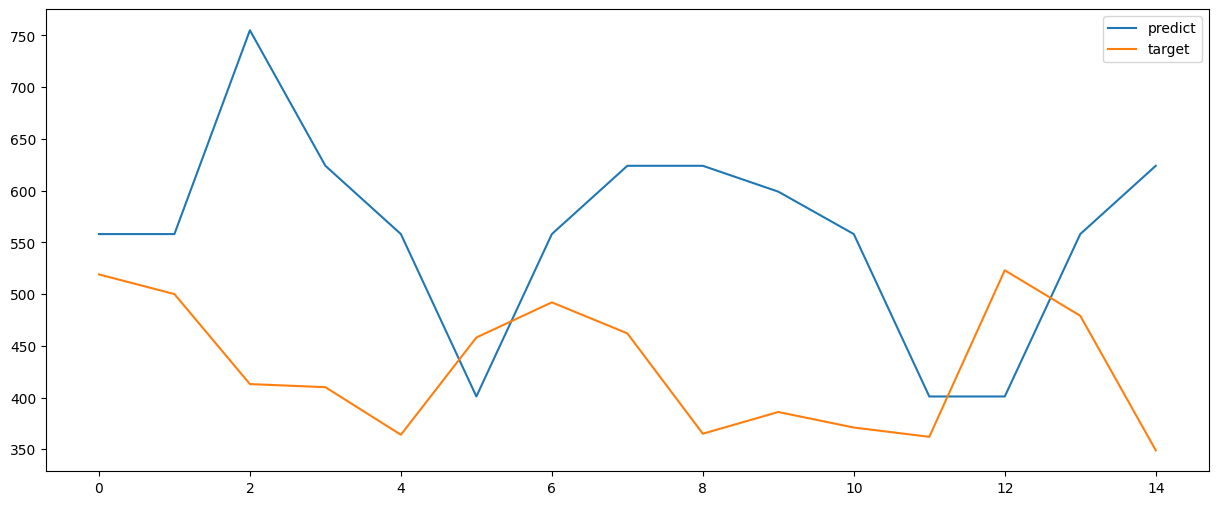

In [71]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [72]:
MSE(y_test, prev_test)

32321.333333333332

### Hyperparameter Tuning

In [73]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depths = [2, 3, 4, 5, 6, 7, 8, 10, 15]
min_samples_split = [2,3,4,5,6]
min_samples_leaf = [1,2,3,4,5]
ccp_alphas = [0.0, 0.001, 0.002, 0.003, 0.004]

best_mse = np.inf
best_criterion = None
best_splitter = None
best_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_ccp_alpha = None

for c in criterion:
  for s in splitter:
    for m in max_depths:
      for mss in min_samples_split:
        for msl in min_samples_leaf:
          for ccp_alpha in ccp_alphas:
            modelo = DecisionTreeRegressor(criterion=c, splitter=s, max_depth=m, min_samples_split=mss, min_samples_leaf=msl, ccp_alpha=ccp_alpha)
            modelo.fit(X_train, y_train)
            prev_val = modelo.predict(X_val)

            mse = MSE(y_val, prev_val)
            if mse < best_mse:
              best_mse = mse
              best_criterion = c
              best_splitter = s
              best_depth = m
              best_min_samples_split = mss
              best_min_samples_leaf = msl
              best_ccp_alpha = ccp_alpha

In [74]:
(best_criterion, best_splitter, best_depth, best_min_samples_split, best_min_samples_leaf, best_ccp_alpha, best_mse)

('squared_error', 'random', 7, 4, 5, 0.002, 686.0048303345023)

In [75]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [76]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

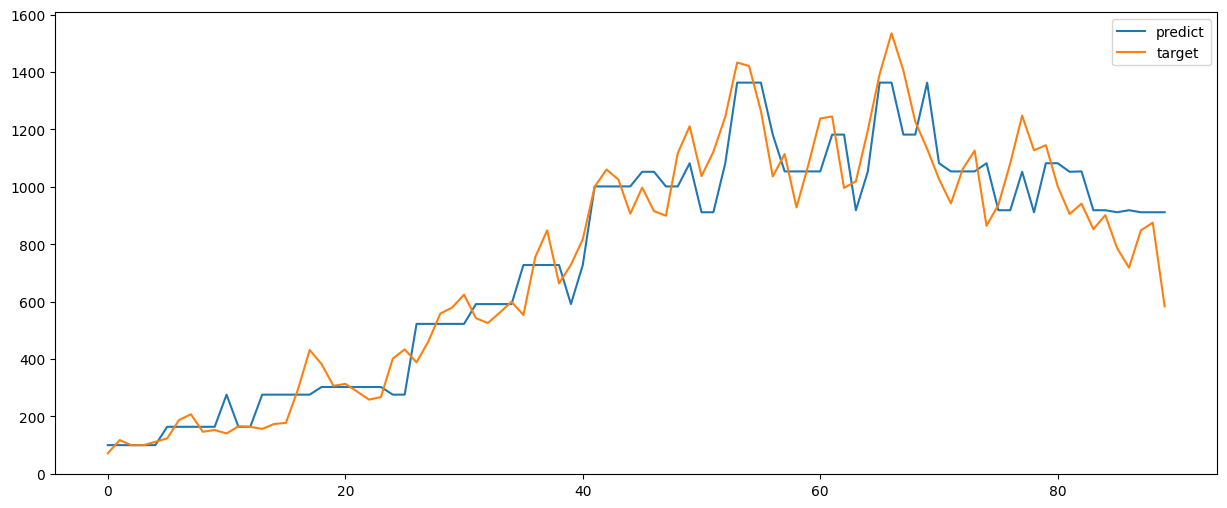

In [77]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [78]:
MSE(y_train_full, prev_train)

12373.971415343916

In [79]:
prev_test = modelo.predict(X_test)

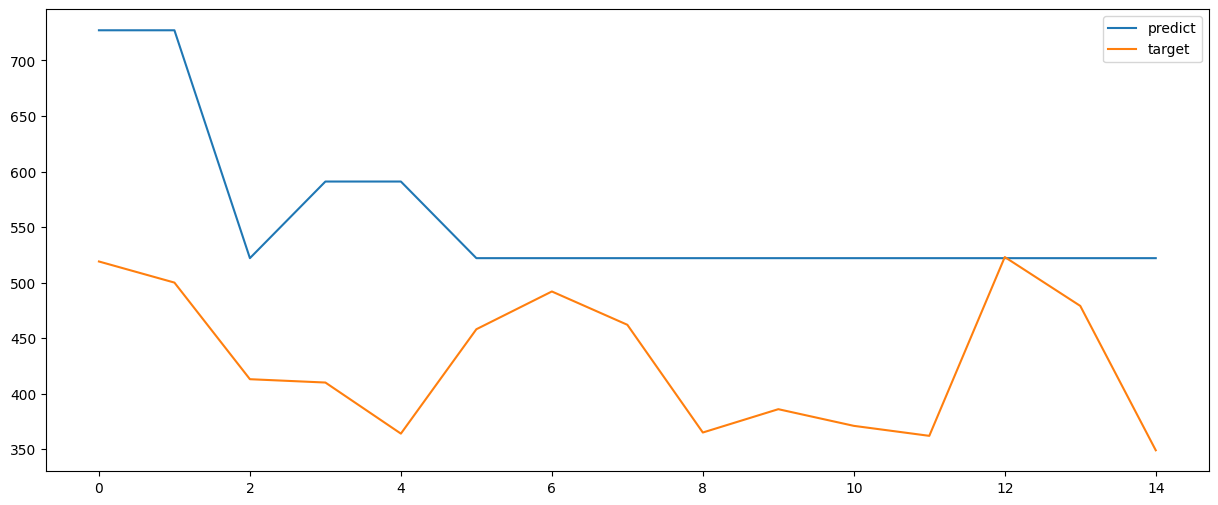

In [80]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [81]:
MSE(y_test, prev_test)

21537.272000000004

## MLPRegressor

In [91]:
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']

best_mse = np.inf
best_activation = None
best_solver = None
best_learning_rate = None

for a in activation:
  for s in solver:
    for l in learning_rate:
        try:
           
          modelo = MLPRegressor(activation=a, solver=s, learning_rate=l)
          modelo.fit(X_train, y_train)
          prev_val = modelo.predict(X_val)
        
        except:
           print(a,s,l)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_activation = a
            best_solver = s
            best_learning_rate = l

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() 

identity sgd constant
identity sgd invscaling


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

identity sgd adaptive


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perce

In [92]:
(best_activation, best_solver, best_learning_rate, best_mse)

('relu', 'lbfgs', 'adaptive', 16315.74296739047)

In [93]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [94]:
modelo = MLPRegressor(activation=best_activation, solver=best_solver, learning_rate=best_learning_rate)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


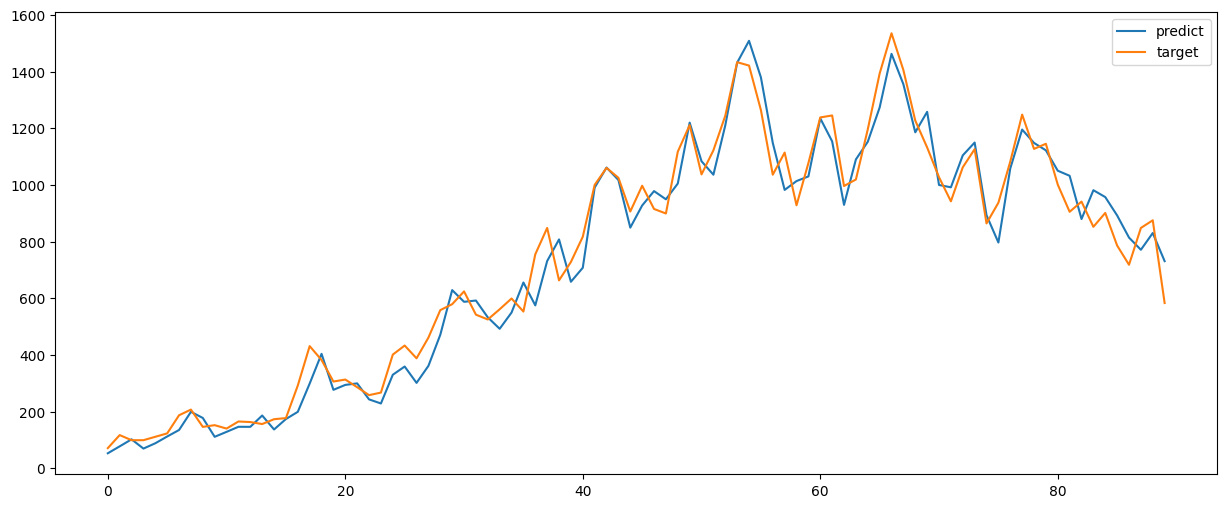

In [95]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [96]:
MSE(y_train_full, prev_train)

5177.906082036971

In [97]:
prev_test = modelo.predict(X_test)

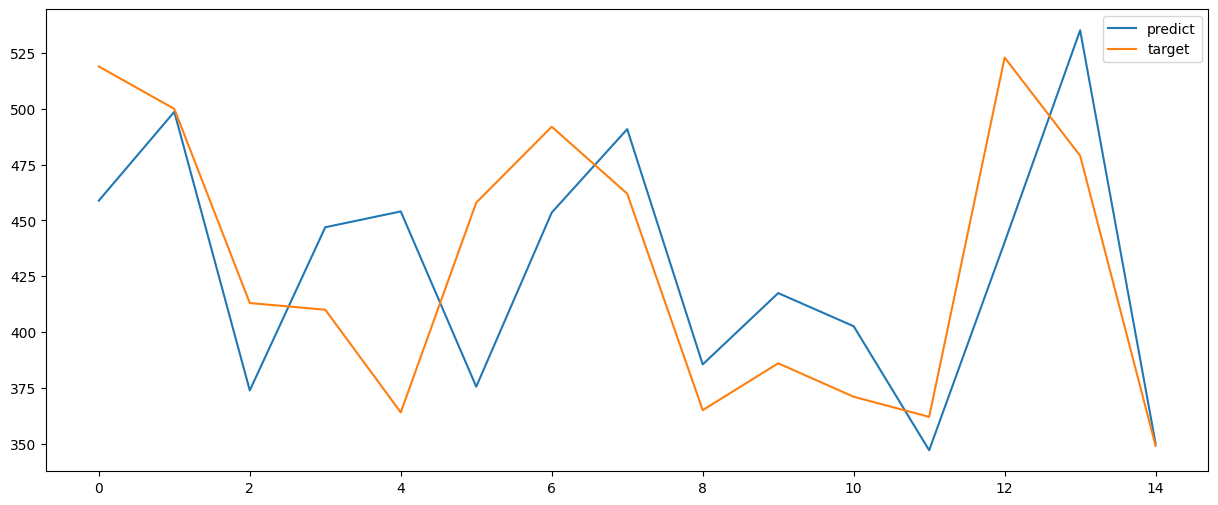

In [98]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [99]:
MSE(y_test, prev_test)

2425.3396712285553